In [1]:
import sys
sys.path.append("../src")

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

# Load dataset and do some preprocessing

In [3]:
train_path = "../data/train.csv"
df_data = pd.read_csv(train_path, sep=",")

#### Setting X

In [4]:
df_features = df_data[df_data.columns.difference(['full_label', 'label'])]
X = df_features.values
print(X.shape)

(29, 15104)


#### Setting y

In [5]:
df_labels = df_data["label"]
y = df_labels.values
print(y.shape)

(29,)


# Feature selection with LASSO

## Impact of the number of trainning iteration on sparcity

In [6]:
n_splits = 5
scores = []
sparcities = []


for k in range (2,6):

    sparcity = 0
    score = 0

    #K-Fold vor validation
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Trainning
        clf_l1_LR = LogisticRegression(penalty='l1', solver='saga', max_iter=10**k, multi_class='multinomial')
        clf_l1_LR.fit(X_train, y_train)

        # Inference
        predictions = clf_l1_LR.predict(X_test)
        score += clf_l1_LR.score(X_test, y_test)

        #Sparcity measurement
        coef_l1_LR = clf_l1_LR.coef_.ravel()
        sparcity += np.mean(coef_l1_LR == 0) * 100

    print("Score for 1e{} :".format(k), score/n_splits)
    print("Sparcity for 1e{} :".format(k), sparcity/n_splits)

    scores.append(score/n_splits)
    sparcities.append(sparcity/n_splits)

Score for 1e2 : 0.06666666666666667
Sparcity for 1e2 : 70.85275423728812
Score for 1e3 : 0.2733333333333333
Sparcity for 1e3 : 91.36475988700565
Score for 1e4 : 0.44000000000000006
Sparcity for 1e4 : 97.92593573446327
Score for 1e5 : 0.44000000000000006
Sparcity for 1e5 : 97.92593573446327


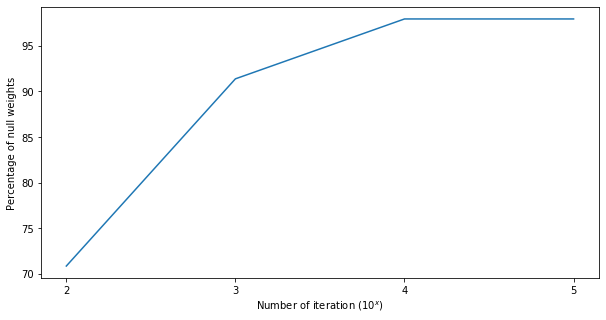

In [13]:
num_iteration = np.arange(2,6,1)
plt.figure(figsize=(10,5))
plt.plot(num_iteration,sparcities)
plt.xlabel("Number of iteration ($10^x$)")
plt.ylabel("Percentage of null weights")
plt.xticks(num_iteration)
plt.show()

# Find most relevant values

In [23]:
clf_l1_LR = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, multi_class='multinomial')
clf_l1_LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## Extract non null weights and corresponding labels

In [24]:
label_features_name = {}
label_features_weight = {}
for i,cat_features in enumerate(clf_l1_LR.coef_):
    relevant_features = np.where(cat_features != 0)
    label_features_name[i] = df_features.columns[relevant_features].to_list()
    label_features_weight[i] = cat_features[relevant_features]
    print("Number of relevant features for category {} :".format(i),len(relevant_features[0]))

Number of relevant features for category 0 : 333
Number of relevant features for category 1 : 295
Number of relevant features for category 2 : 448


## Sort features by weigth importance

In [25]:
import collections
label_dictionary = {}
top_n_values = {}
top_n = 20

for i in range(3):
    d = dict(zip(label_features_name[i],label_features_weight[i]))
    label_dictionary[i] = collections.OrderedDict({k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)})
    top_n_values[i] = list(label_dictionary[i].items())[:top_n]
    

## Plot most important features for each labels

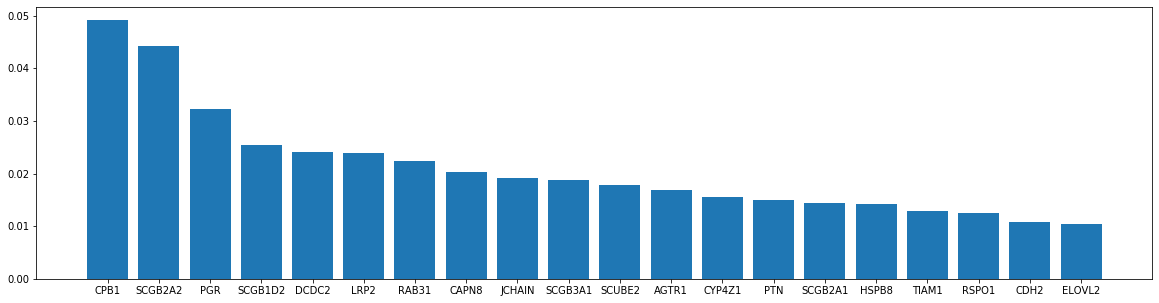

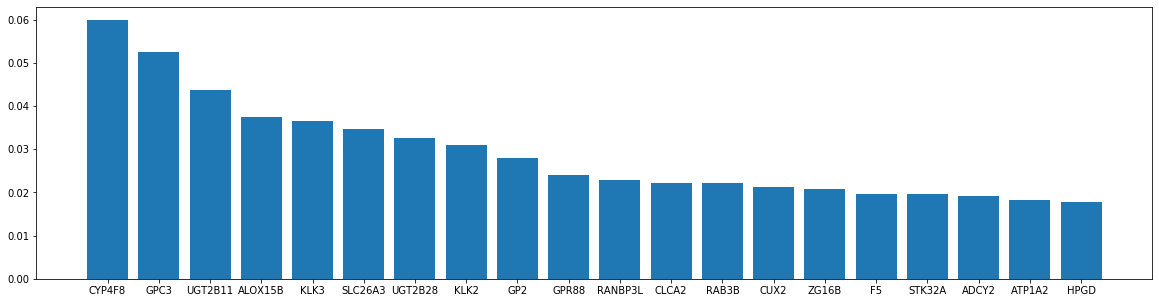

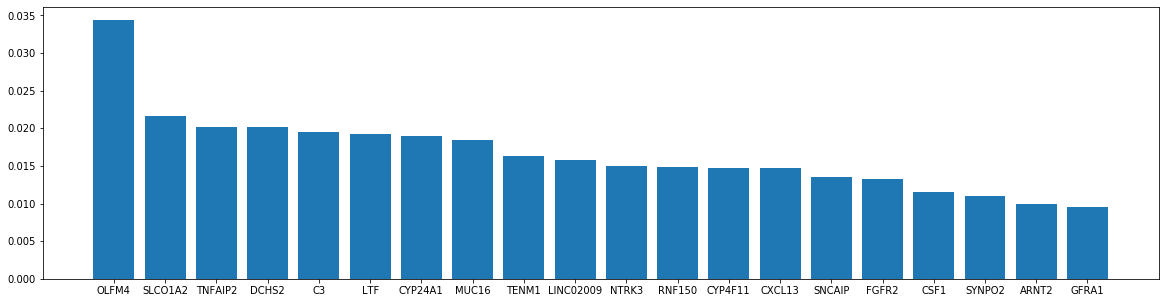

In [26]:
for k in range(3):
    labels, value = zip(*top_n_values[k])
    plt.figure(figsize=(20,5))
    plt.bar(labels, value)

## Check how much are in the provided important features

In [41]:
label_dictionary = {}
top_n_values = {}
top_n = 50

for i in range(3):
    d = dict(zip(label_features_name[i],label_features_weight[i]))
    label_dictionary[i] = collections.OrderedDict({k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)})
    top_n_values[i] = list(label_dictionary[i].items())[:top_n]

In [81]:
relevant_features = pd.read_csv("../data/important_genes.csv", sep=",")
relevant_features_array = relevant_features.values.flatten()

In [82]:
label_1 = [top_n_values[0][k][0] for k in range(len(top_n_values[0]))]
label_2 = [top_n_values[1][k][0] for k in range(len(top_n_values[1]))]
label_3 = [top_n_values[2][k][0] for k in range(len(top_n_values[2]))]

shared_features = []
for gene in relevant_features_array:
    if gene in label_1+label_2+label_3:
        if gene not in shared_features:
            shared_features.append(gene)
            
print("Ratio", len(shared_features)/len(relevant_features_array))
print("Shared features \n", shared_features)

Ratio 0.7321428571428571
Shared features 
 ['KLK3', 'SCGB2A1', 'KLK2', 'LRP2', 'CELSR1', 'SLC26A3', 'CXCL13', 'SCGB1D2', 'CUX2', 'GRIK3', 'SCGB2A2', 'UGT2B28', 'CAPN8', 'PGR', 'GPR88', 'TENM1', 'GPC3', 'DCHS2', 'GP2', 'ELOVL2', 'SOX11', 'ALOX15B', 'SLCO1A2', 'UGT2B11', 'CYP4Z1', 'RNF150', 'CYP4F8', 'CITED1', 'SYNPO2', 'ATP1A2', 'PDZK1', 'RANBP3L', 'FGFR2', 'ROBO2', 'KIAA1549L', 'RAB3B', 'ADCY2', 'CNMD', 'SERHL2', 'HPGD', 'FGFR4']


# Feature selection with PCA

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1','PC 2'])

In [70]:
features_of_component_1 = abs( pca.components_ )[0]
indices_component_1 = features_of_component_1.argsort()[-50:][::-1]

In [71]:
features_labels_of_component_1 = df_features.columns[indices_component_1].to_list()

In [78]:
print(features_labels_of_component_1)

['RN7SL2', 'RPS18', 'HSPA1A', 'SCARNA21', 'H19', 'HSPA1B', 'RPS9', 'HLA-E', 'SCARNA7', 'EEF1D', 'SNORD3A', 'CLIC1', 'TUBB', 'SCARNA5', 'RPS17', 'TC2N', 'FOSB', 'DDR1', 'JUNB', 'SNORD17', 'BDP1', 'RPL41', 'SLC25A6', 'BRD2', 'PRPF8', 'KRT16', 'RGL2', 'MTCO3P12', 'SCARNA13', 'LENG8', 'CLDN4', 'NEU1', 'MTRNR2L1', 'DDX24', 'PPP1R10', 'HIST1H1E', 'SCGB3A1', 'KRT17', 'HIST1H4E', 'PPP1R15A', 'IER3', 'LIF', 'SLC25A25', 'ITPKC', 'RNH1', 'MLLT6', 'HIST2H2AC', 'RN7SL3', 'PUF60', 'DLG5']


In [84]:
features_of_component_2 = abs( pca.components_ )[1]
indices_component_2 = features_of_component_2.argsort()[-50:][::-1]

In [85]:
features_labels_of_component_2 = df_features.columns[indices_component_2].to_list()

In [86]:
print(features_labels_of_component_2)

['LIF', 'SGMS2', 'CYP24A1', 'LAMC2', 'LUCAT1', 'BIRC3', 'CPB1', 'IL6R', 'MAP3K8', 'SERPINB5', 'CCDC150P1', 'GPAT3', 'ANKRD36C', 'RCAN1', 'KRT16', 'NAMPT', 'CLDN1', 'ITPKC', 'ALDH1A3', 'PLAUR', 'MIR222HG', 'CTSV', 'OCLN', 'KRT6B', 'ENG', 'TC2N', 'MPZL3', 'ADAMTS4', 'INSIG1', 'ATF3', 'SLC6A14', 'AC013394.1', 'SOD2', 'EZR', 'RAP2B', 'DUSP14', 'CXCL8', 'KRT23', 'DAPP1', 'PDK4', 'LRAT', 'LDLR', 'CSRNP1', 'NCOA7', 'GLIPR1', 'GPRC5A', 'GADD45A', 'FAM60A', 'CLDN4', 'CD34']


In [87]:
shared_features_pca = []
for gene in relevant_features_array:
    if (gene in features_labels_of_component_2) or (gene in features_labels_of_component_1):
        print('ok')
        if gene not in shared_features_pca:
            shared_features_pca.append(gene)
            
print("Ratio", len(shared_features_pca)/len(relevant_features_array))
print("Shared features \n", shared_features_pca)

Ratio 0.0
Shared features 
 []
